# CNN to dog breeds

In this notebook, I aim to apply Tensorflow and Pytorch AI frameworks to classify different Dog breed given an image.

Therefore, we proceed to present different points, as follows:
1. the data,
2. the NN implemented in TF,
3. the explainability applied, and
4. a pre-trained model that presents a high accuracy.

## Data

In [18]:
# Import libraries
# import pandas as pd
import glob
from PIL import Image
from IPython.display import Image as image_i
import os
import numpy as np
import matplotlib.pyplot as plt

### Auxiliar functions

In [19]:
# Auxiliar function to drop corrupt images
def check_imgs(path):
    errors = []
    for folder, _, files in os.walk(path):
        for file in files:
            path_tmp = os.path.join(folder, file)
            try:
                with Image.open(path_tmp) as img:
                    img.verify()
            except Exception as e:
                errors.append(path_tmp)
    return errors

In [20]:
def drop_corrupt_imgs(path):
    n = 0
    subfolders = [f.path for f in os.scandir(path) if f.is_dir()]
    for subfolder in subfolders:
        path_tmp = os.path.join(path, subfolder)
        corrupt_imgs = check_imgs(path_tmp)
        for ruta in corrupt_imgs:
            os.remove(ruta)
            n+=1
    print(f"We have removed {n} corrupt images.")

### Load data

In [21]:
# Load the dog images (.jpg extension)
dog_images = glob.glob("dogimages/**/*.jpg", recursive=True)
num_dog_images = len(dog_images)
print(f"There are {num_dog_images} dog images.")

There are 8351 dog images.


In [22]:
# Train
train_dog_images = glob.glob("dogimages/train/**/*.jpg", recursive=True)
num_train_dog_images = len(train_dog_images)
print(f"There are {num_train_dog_images} dog images for train.")

There are 6680 dog images for train.


In [23]:
# Validation
val_dog_images = glob.glob("dogimages/valid/**/*.jpg", recursive=True)
num_val_dog_images = len(val_dog_images)
print(f"There are {num_val_dog_images} dog images for validation.")

There are 835 dog images for validation.


In [24]:
# Test
test_dog_images = glob.glob("dogimages/test/**/*.jpg", recursive=True)
num_test_dog_images = len(test_dog_images)
print(f"There are {num_test_dog_images} dog images for test.")

There are 836 dog images for test.


In [25]:
# We check that there is no any wrong or missing image
assert num_dog_images == num_train_dog_images + num_val_dog_images + num_test_dog_images

In [26]:
# We check corrupt images
path = os.path.join(os.getcwd(), "dogimages")
train_path = os.path.join(path, "train")
valid_path = os.path.join(path, "valid")
test_path = os.path.join(path, "test")
print(f"Cheking train in {train_path}...")
drop_corrupt_imgs(train_path)
print(f"Cheking valid in {valid_path}...")
drop_corrupt_imgs(valid_path)
print(f"Cheking test in {test_path}...")
drop_corrupt_imgs(test_path)

Cheking train in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\train...
We have removed 0 corrupt images.
Cheking valid in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\valid...
We have removed 0 corrupt images.
Cheking test in c:\Users\alvar\Desktop\Portfolio\CNN-dog-breed\dogimages\test...
We have removed 0 corrupt images.


In [27]:
# Different breeds
dog_breeds = glob.glob("dogimages/train/*")
dog_breeds = [dog_breed_tmp.split(".")[1] for dog_breed_tmp in dog_breeds]

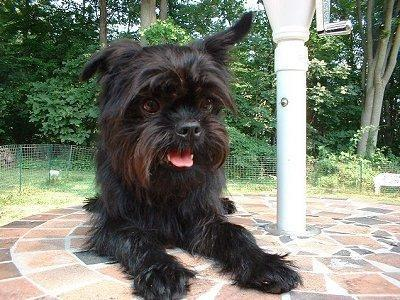

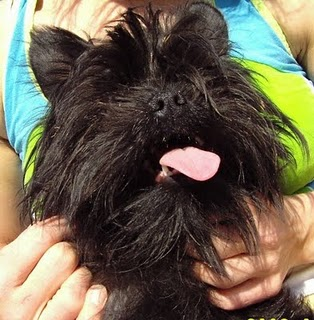

In [28]:
display(image_i(filename=train_dog_images[0]))
display(image_i(filename=test_dog_images[0]))

## CNN in Tensorflow

In [29]:
# Import libraries
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

In [30]:
# Image size redimension
IMG_SIZE = (224, 224)
# Images per Batch (bigger = more RAM)
BATCH_SIZE = 20
# Carga las imágenes desde la carpeta "data/train"
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/train",      # Path
    image_size=IMG_SIZE,    # Image redimension -> 128x128
    batch_size=BATCH_SIZE,  # Groups (batchs) of 32 images
    shuffle=True            # To improve the training process
)

# Same for validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


# Same for test
test_ds = tf.keras.utils.image_dataset_from_directory(
    "dogimages/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# We automatically obtain the classes
class_names = train_ds.class_names
print("Clases encontradas:", class_names)

Found 6680 files belonging to 133 classes.
Found 835 files belonging to 133 classes.
Found 836 files belonging to 133 classes.
Clases encontradas: ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Bru

In [31]:
print(f"As there are {len(class_names)} breeds, there is a possibily of a random correct value of {1/len(class_names)}%")

As there are 133 breeds, there is a possibily of a random correct value of 0.007518796992481203%


In [32]:
# TensorFlow can automatically optimize the number of threads when loading data
AUTOTUNE = tf.data.AUTOTUNE

# Pixels from inter [0,255] to float [0.0,1.0]
def preprocess(ds):
    return ds.map(
        lambda x, y: (tf.cast(x, tf.float32) / 255.0, y),  # Image normalizarion
        num_parallel_calls=AUTOTUNE
    )

# Train
train_ds = (
    preprocess(train_ds)             # Image normalization
    .cache()                         # Save data after first usage
    .shuffle(1000)                   # Shuffle to improve the training process
    .prefetch(buffer_size=AUTOTUNE)  # Preparing next batch whereas this is training (remember: parallel mode is active)
)

# Validation
val_ds = (
    preprocess(val_ds)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Test
test_ds = (
    preprocess(test_ds)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

### Functional

In [ ]:
# Define the net
def build_functional_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, (3, 3), padding='same', use_bias=False)(inputs)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.2)(x)

    # we name this layer to load it at Grad-CAM
    x = Conv2D(128, (3, 3), padding='same', use_bias=False, name='last_conv')(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [25]:
# Compile
model = build_functional_model((*IMG_SIZE, 3), len(class_names))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 32)     │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 32)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv2D)              │ (None, 4, 4, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 133)            │        68,22

 Total params: 1,215,237 (4.64 MB)

 Trainable params: 1,214,757 (4.63 MB)

 Non-trainable params: 480 (1.88 KB)

In [35]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.0152 - loss: 4.9611

c:\Users\alvar\miniconda3\envs\dog-env\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


334/334 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step - accuracy: 0.0152 - loss: 4.9605 - val_accuracy: 0.0132 - val_loss: 4.8181
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 77s 229ms/step - accuracy: 0.0458 - loss: 4.4085 - val_accuracy: 0.0395 - val_loss: 4.4019
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 75s 226ms/step - accuracy: 0.0665 - loss: 4.1853 - val_accuracy: 0.0431 - val_loss: 4.4372
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 76s 228ms/step - accuracy: 0.0804 - loss: 3.9727 - val_accuracy: 0.0455 - val_loss: 4.2241
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 76s 229ms/step - accuracy: 0.0998 - loss: 3.8406 - val_accuracy: 0.0311 - val_loss: 4.8830
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 75s 225ms/step - accuracy: 0.1124 - loss: 3.7665 - val_accuracy: 0.0623 - val_loss: 4.2566
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 76s 227ms/step - accuracy: 0.1237 - loss: 3.6362 - val_accuracy: 0.0850 - val_loss: 4.0697
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 77s 229ms/step - accuracy: 0.1232 - loss: 3.5557 - val

In [ ]:
# Test the test data (without being used until now)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

**Note**: I discard a Sequential model because this model due to it does not let apply explainability

## Explainability: gradcam

In [ ]:
import cv2

In [ ]:
# Grad Cam
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def show_gradcam(img_path, model, last_conv_layer_name, preprocess_fn=None):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    if preprocess_fn:
        img_array = preprocess_fn(img_array)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Superponer
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * 0.4 + img
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(np.uint8(superimposed_img), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

c:\Users\alvar\miniconda3\envs\dog-env\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
C:\Users\alvar\AppData\Local\Temp\ipykernel_12260\1338741553.py:16: RuntimeWarning: invalid value encountered in cast
  heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)


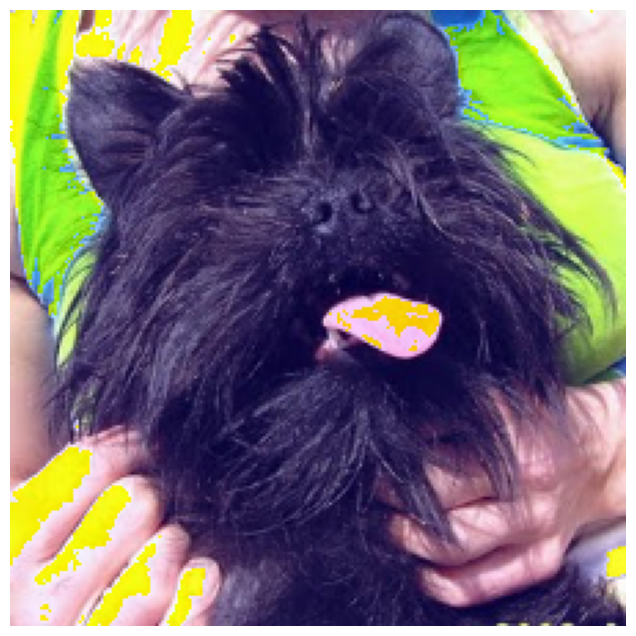

In [36]:
# Execute the gradcam
show_gradcam(test_dog_images[0], model, last_conv_layer_name="last_conv")

## Transfer learning (pre-trained model)

As the accuracy is low, we try with a pre-trained model.

### InceptionV3

In [33]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
base_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False # because is a pre-trained model

In [ ]:
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False) # because is a pre-trained model
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
333/334 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5159 - loss: 2.3999

c:\Users\alvar\miniconda3\envs\dog-env\lib\site-packages\keras\src\trainers\epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


334/334 ━━━━━━━━━━━━━━━━━━━━ 129s 385ms/step - accuracy: 0.5164 - loss: 2.3966 - val_accuracy: 0.8335 - val_loss: 0.6179
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 124s 373ms/step - accuracy: 0.8654 - loss: 0.4221 - val_accuracy: 0.8204 - val_loss: 0.6649
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 124s 371ms/step - accuracy: 0.9168 - loss: 0.2573 - val_accuracy: 0.8311 - val_loss: 0.6218
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 123s 368ms/step - accuracy: 0.9327 - loss: 0.1980 - val_accuracy: 0.8204 - val_loss: 0.6957
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 123s 369ms/step - accuracy: 0.9534 - loss: 0.1519 - val_accuracy: 0.8323 - val_loss: 0.6584
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 124s 372ms/step - accuracy: 0.9566 - loss: 0.1230 - val_accuracy: 0.8072 - val_loss: 0.7607
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 127s 380ms/step - accuracy: 0.9614 - loss: 0.1111 - val_accuracy: 0.8491 - val_loss: 0.6405
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 130s 390ms/step - accuracy: 0.9803 - loss: 0.06

In [39]:
# Test the test data (without being used until now)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 327ms/step - accuracy: 0.8293 - loss: 0.7308
Test Accuracy: 82.42%
